In [1]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from estimation_fct import *

In [2]:
# Load model
from model import ModelClass

model = ModelClass() 

par = model.par
sol = model.sol
sim = model.sim

model.solve()
model.simulate()

c:\Design_retirement\model.py:135: RuntimeWarning: invalid value encountered in divide
  np.cumsum(S[::-1])[::-1] / S,


In [3]:
# Prepare data
mean, weights, moments = prepare_data(par)

In [4]:
# Prepare SMM
theta_names = ("beta", "sigma", "gamma", "mu", "zeta", "r_a", "r_s")
theta_init = np.array([0.991, 1.126, 7.350, 9.986, 5.0, 0.007, 0.01 ])

# Original bounds
orig_bounds = [(0.0, 1.0),   # beta
               (0.1, 6.0),   # sigma
               (0.1, 10.0),  # gamma
               (0.0, 10.0),  # mu
               (0.0, 50.0),  # zeta
               (0.0, 10.0),   # r_a_in
               (0.0, 10.0),   # r_s_in
               ] 

theta_init_scaled = scale_params(theta_init, orig_bounds)

In [ ]:
# Do SMM
objective = lambda theta: obj_func(theta, theta_names, mean, weights, model, orig_bounds, do_print=True)

res = minimize(
    objective, 
    theta_init_scaled,
    method='Nelder-Mead',
    bounds=[(0,1)] * len(theta_init_scaled),
    tol=1e-6,
    options={"maxiter":100}
)


beta=0.991 sigma=1.126 gamma=7.350 mu=9.986 zeta=5.000 r_a=0.007 r_s=0.010 
Error = 15.35, Time = 72.7953 seconds
beta=0.959 sigma=1.126 gamma=7.350 mu=9.986 zeta=5.000 r_a=0.007 r_s=0.010 
Error = 12.79, Time = 74.1930 seconds
beta=0.991 sigma=1.177 gamma=7.350 mu=9.986 zeta=5.000 r_a=0.007 r_s=0.010 
Error = 8.75, Time = 84.4925 seconds
beta=0.991 sigma=1.126 gamma=7.712 mu=9.986 zeta=5.000 r_a=0.007 r_s=0.010 
Error = 15.37, Time = 79.1080 seconds
beta=0.991 sigma=1.126 gamma=7.350 mu=9.515 zeta=5.000 r_a=0.007 r_s=0.010 
Error = 14.75, Time = 81.7540 seconds
beta=0.991 sigma=1.126 gamma=7.350 mu=9.986 zeta=5.250 r_a=0.007 r_s=0.010 
Error = 14.71, Time = 95.3472 seconds
beta=0.991 sigma=1.126 gamma=7.350 mu=9.986 zeta=5.000 r_a=0.007 r_s=0.010 
Error = 15.65, Time = 81.8882 seconds
beta=0.991 sigma=1.126 gamma=7.350 mu=9.986 zeta=5.000 r_a=0.007 r_s=0.011 
Error = 15.66, Time = 80.7348 seconds
beta=0.982 sigma=1.141 gamma=7.454 mu=9.851 zeta=5.071 r_a=0.007 r_s=0.009 
Error = 8.45,

In [ ]:
# Load the model with calibrated values
theta_names = ("beta", "sigma", "gamma", "mu", "zeta", "r_a", "r_s")
# theta_final = np.array([0.991, 1.126, 7.350, 9.986, 10.0, 0.7, 1.1 ])
theta_final = unscale_params(res.x, orig_bounds)
# theta_final = np.array([0.961, 1.127, 2.645, 6.657, 0.009, 0.041])
# theta_final = np.array([0.982, 1.060, 3.877, 7.814, 0.02, 0.009])

# for i, name in enumerate(theta_names):
#     setattr(model.par, name, theta_final[i])

model.solve()
model.simulate()

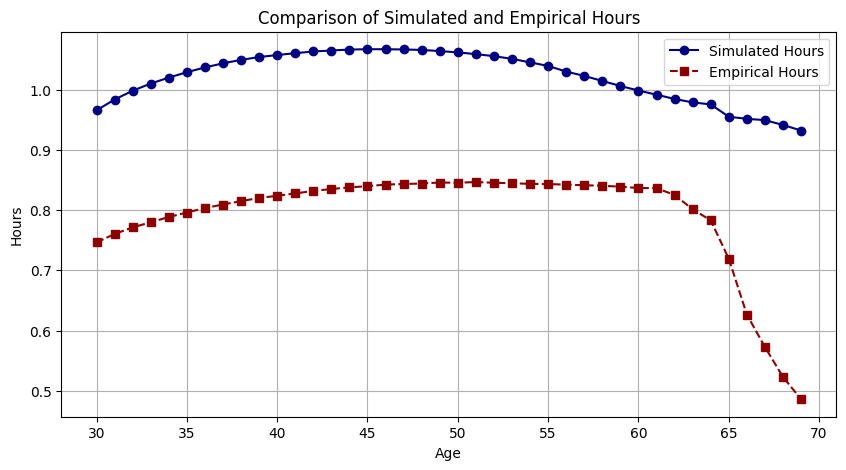

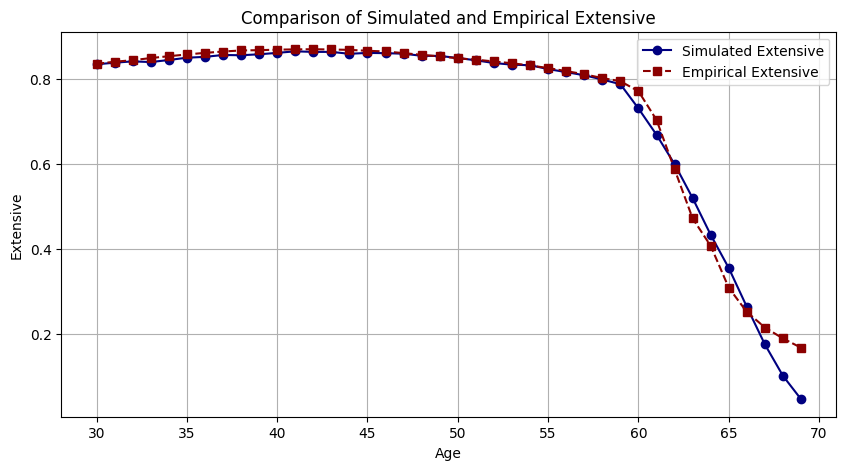

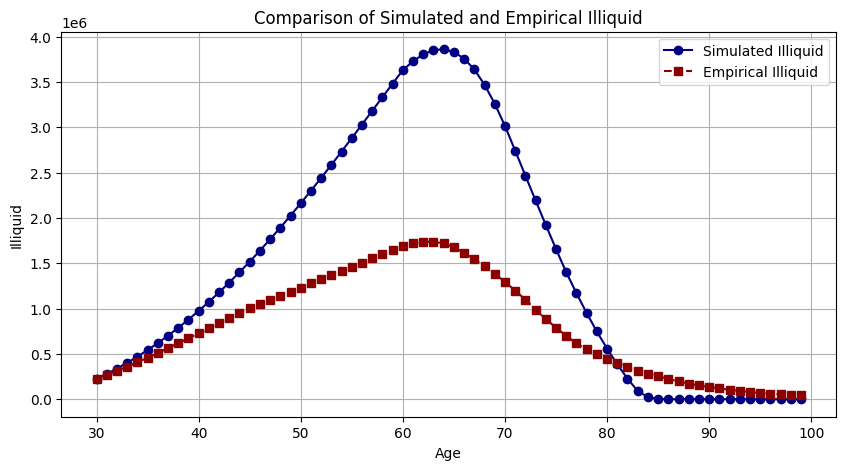

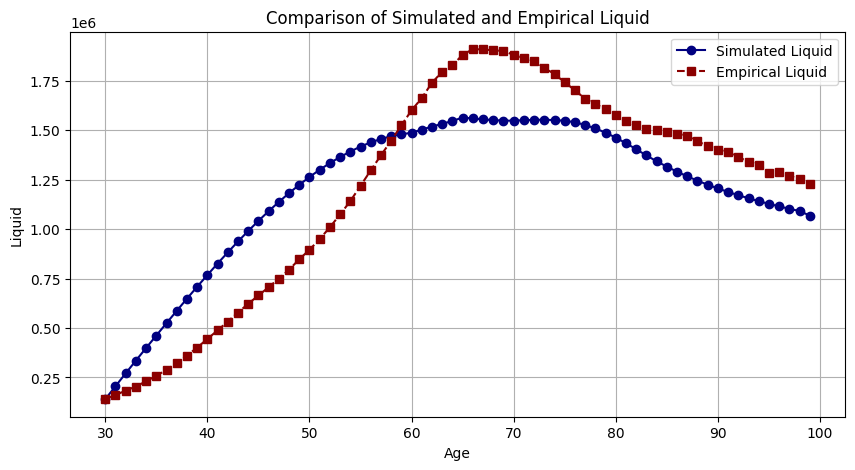

In [ ]:
# plot the graph with calibrated values 
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan),axis=0)[:40], moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40], moments['extensive']],
    'illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None), moments['savings']],
    'liquid': [np.mean(model.sim.a, axis=0), moments['assets']]
}

# Define colors
simulated_color = "navy"  # Dark blue
empirical_color = "darkred"  # Dark red
ci_color = "lightcoral"  # Light red for confidence bands

for key, (simulated, empirical) in a_dict.items():
    plt.figure(figsize=(10, 5))
    
    x_vals = np.arange(len(empirical)) + par.start_age
    
    plt.plot(x_vals, simulated, label=f"Simulated {key.capitalize()}", marker="o", color=simulated_color)
    plt.plot(x_vals, empirical, label=f"Empirical {key.capitalize()}", linestyle="--", marker="s", color=empirical_color)

    # # 99.9% confidence interval
    # ci = std_dev
    # plt.fill_between(x_vals, empirical - ci, empirical + ci, color=ci_color, alpha=0.4, label="Empirical Standard Deviation")

    plt.xlabel("Age")
    plt.ylabel(key.capitalize())
    plt.title(f"Comparison of Simulated and Empirical {key.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()


Old best variables:

In [ ]:
theta_old = ([0.982, 1.060, 3.877, 7.814, 0.02, 0.009])